### Data wrangling

Import Libraries

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pathlib
import zipfile
from glob import glob
from math import floor, ceil

import pandas as pd
import geopandas as gpd
import rioxarray as rxr
from rioxarray.merge import merge_arrays # Merge rasters

import matplotlib.pyplot as plt
# interactive plots of vector data
import hvplot.pandas

import earthaccess

Set Paths

In [39]:
# Images
images_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'images'
)

# Datasets
datasets_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'datasets'
)

# Project data directory 
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'data'
)

# Define directories for data
land_units_dir = os.path.join(data_dir, 'usfs-national-lands')
eldorado_elevation_dir = os.path.join(data_dir, 'srtm', 'eldorado')
los_padres_elevation_dir = os.path.join(data_dir, 'srtm', 'los_padres')

os.makedirs(images_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(eldorado_elevation_dir, exist_ok=True)
os.makedirs(los_padres_elevation_dir, exist_ok=True)

Load Utility Functions

In [58]:
def build_da(urls, bounds):
    """Build a DataArray from a set of urls"""
    all_das = []

    for url in urls:
        # Open data granule, mask missing data, scale data, and remove dimensions of length 1
        tile_da = rxr.open_rasterio(
                url,
                # For the fill/missing value
                mask_and_scale=True
            ).squeeze()
        # Unpack the bounds and crop tile
        cropped_da = tile_da.rio.clip_box(*bounds)
        all_das.append(cropped_da)

    merged = merge_arrays(all_das)
    return merged

In [60]:
def plot_site(site_da, site_gdf, site_fig_name, plot_title, bar_label, plot_cmap, boundary_clr):
    """Create custom site plot"""
    fig = plt.figure(figsize=(8, 6)) 
    ax = plt.axes()

    # Plot DataArray values
    site_plot = site_da.plot(cmap=plot_cmap, cbar_kwargs={'label': bar_label})

    # Plot site boundary
    site_gdf.boundary.plot(ax=plt.gca(), color=boundary_clr)

    plt.title(f'{plot_title}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    fig.savefig(f"{images_dir}/{site_fig_name}.png") 

    return site_plot

Load Data

In [13]:
# Only extract once
usfs_pattern = os.path.join(land_units_dir, '*.shp')

if not glob(usfs_pattern):
    usfs_zip = f'{datasets_dir}/S_USA.NFSLandUnit.zip'

    # Unzip data
    with zipfile.ZipFile(usfs_zip, 'r') as zip:
        zip.extractall(path=land_units_dir)

# Find the extracted .shp file path
usfs_land_path = glob(usfs_pattern)[0]

# Load USFS land units from shapefile
usfs_land_units_gdf = (
    gpd.read_file(usfs_land_path)
)

# Obtain units with location name
valid_units = usfs_land_units_gdf.dropna(subset=['HQ_LOCATIO'])

# Select only CA units
all_ca_units = valid_units[valid_units['HQ_LOCATIO'].str.contains('CA')]

In [16]:
earthaccess.login(strategy="interactive", persist=True)

In [18]:
# Search for Digital Elevation Models

ea_dem = earthaccess.search_datasets(keyword='SRTM DEM', count=15)
for dataset in ea_dem:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
GFSAD30EUCEARUMECE Global Food Security-support Analysis Data (GFSAD) Cropland Extent 2015 Europe, Central Asia, Russia, Middle East product 30 m V001
GFSAD30SA

Explore Sites

In [19]:
# Los Padres National Forest
los_padres_gdf = all_ca_units.loc[all_ca_units['NFSLANDU_2'] == 'Los Padres National Forest']

# plot with EsriImagery basemap  
los_padres_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Los Padres National Forest',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [20]:
# Eldorado National Forest
eldorado_gdf = all_ca_units.loc[all_ca_units['NFSLANDU_2'] == 'Eldorado National Forest']

# plot with EsriImagery basemap  
eldorado_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Eldorado National Forest',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

Identify Soil Metric

In [42]:
def create_polaris_urls(soil_prop, stat, soil_depth, gdf_bounds):
    """Create POLARIS dataset urls using site bounds"""

    # Get latitude and longitude bounds from site
    min_lon, min_lat, max_lon, max_lat = gdf_bounds

    site_min_lon = floor(min_lon) 
    site_min_lat = floor(min_lat)  
    site_max_lon = ceil(max_lon)  
    site_max_lat = ceil(max_lat)

    all_soil_urls = []

    for lon in range(site_min_lon, site_max_lon):
        for lat in range(site_min_lat, site_max_lat):
            current_max_lon = lon + 1
            current_max_lat = lat + 1

            soil_template = (
                "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
                "{soil_prop}/"
                "{stat}/"
                "{soil_depth}/"
                "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
            )

            soil_url = soil_template.format(
                soil_prop=soil_prop, stat=stat, soil_depth=soil_depth,
                min_lat=lat, max_lat=current_max_lat, 
                min_lon=lon, max_lon=current_max_lon
            )

            all_soil_urls.append(soil_url)

    return all_soil_urls

In [48]:
# Set site parameters
soil_prop = 'ph'
soil_prop_stat = 'mean'
# cm (the minimum depth for blue oaks is 1-2 ft)
soil_depth = '30_60'

# Build soil DataArrays 

# Eldorado site
ed_polaris_urls = create_polaris_urls(soil_prop, soil_prop_stat, soil_depth, eldorado_gdf.total_bounds)
eldorado_da = build_da(ed_polaris_urls, tuple(eldorado_gdf.total_bounds))

# Los Padres site
lp_polaris_urls = create_polaris_urls(soil_prop, soil_prop_stat, soil_depth, los_padres_gdf.total_bounds)
los_padres_da = build_da(lp_polaris_urls, tuple(los_padres_gdf.total_bounds))

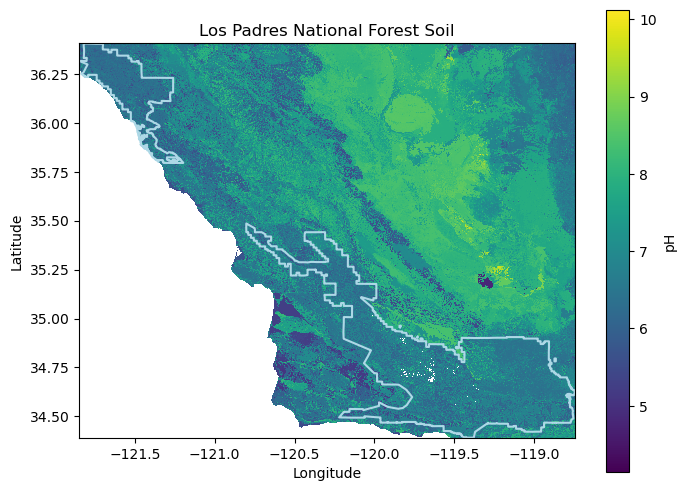

In [61]:
# Plot Los Padres soils

los_padres_soil_plt = plot_site(
    los_padres_da, los_padres_gdf, 
    'Los-Padres-National-Forest-Soil', 
    'Los Padres National Forest Soil', 
    'pH', 'viridis', 'lightblue'
)

los_padres_soil_plt

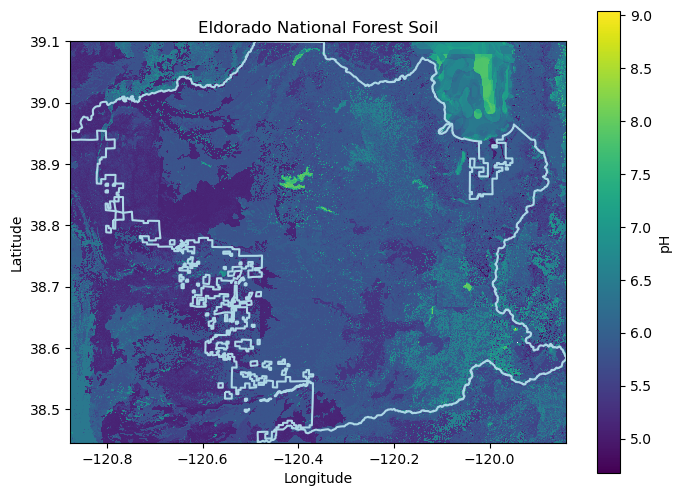

In [62]:
# Plot Eldorado soils

eldorado_soil_plt = plot_site(
    eldorado_da, eldorado_gdf, 
    'Eldorado-National-Forest-Soil', 
    'Eldorado National Forest Soil', 
    'pH', 'viridis', 'lightblue'
)

eldorado_soil_plt

Select Digital Elevation Model

In [65]:
def select_dem(bounds, site_gdf, download_dir):
    """Create elevation DataArray from NASA Shuttle Radar Topography Mission data"""

    # Returns data granules for given bounds
    strm_granules = earthaccess.search_data(
        # SRTMGL1: NASA Shuttle Radar Topography Mission Global 1 arc second V003
        short_name="SRTMGL1",
        bounding_box=bounds
    )

    # Download data granules
    earthaccess.download(strm_granules, download_dir)

    # Set SRTM data dir. hgt = height 
    strm_pattern = os.path.join(download_dir, '*.hgt.zip')

    # Build merged elevation DataArray
    strm_da = build_da(glob(strm_pattern), tuple(site_gdf.total_bounds))

    return strm_da    

In [66]:
eldorado_elev_da = select_dem(tuple(eldorado_gdf.total_bounds), eldorado_gdf, eldorado_elevation_dir)

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

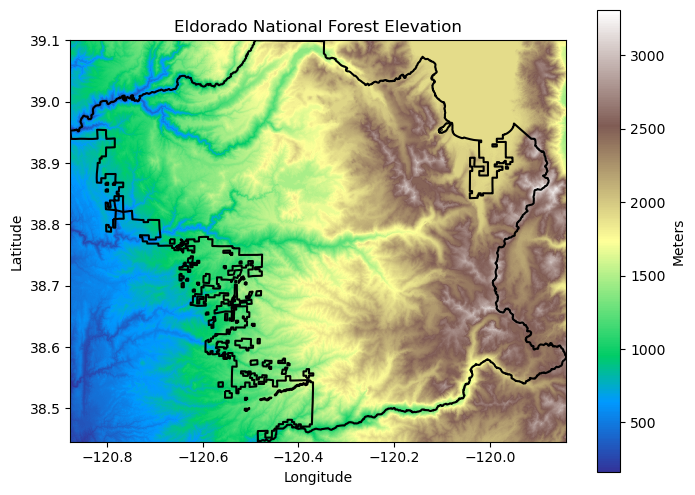

In [67]:
# Plot Eldorado elevation

eldorado_elev_plt = plot_site(
    eldorado_elev_da, eldorado_gdf, 
    'Eldorado-National-Forest-Elevation', 
    'Eldorado National Forest Elevation', 
    'Meters', 'terrain', 'black'
)

eldorado_elev_plt

In [68]:
los_padres_elev_da = select_dem(tuple(los_padres_gdf.total_bounds), los_padres_gdf, los_padres_elevation_dir)

QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/11 [00:00<?, ?it/s]

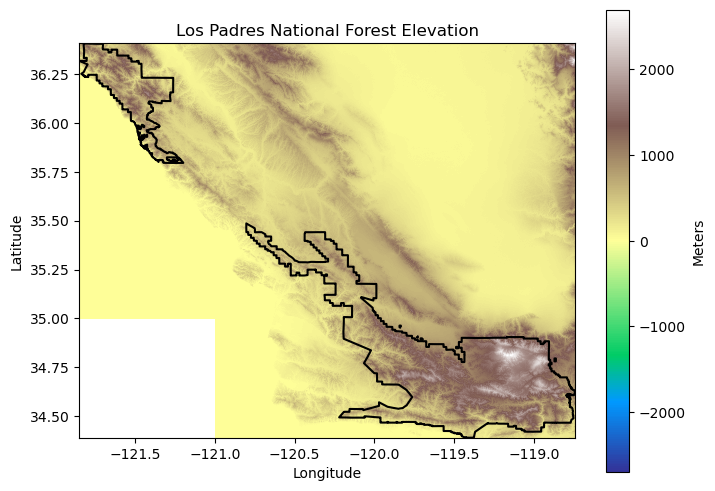

In [69]:
# Plot Los Padres elevation

los_padres_elev_plt = plot_site(
    los_padres_elev_da, los_padres_gdf, 
    'Los-Padres-Forest-Elevation', 
    'Los Padres National Forest Elevation', 
    'Meters', 'terrain', 'black'
)

los_padres_elev_plt